In [ ]:
%pip install --upgrade --quiet tf-nightly-2.0-preview #tf-nightly

In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.0.0-dev20190717


In [2]:
import pandas as pd
import datetime
print(tf.version.VERSION)
import shutil
import os

# serving inputs to model
inputs = {
    'a' : tf.keras.layers.Input(name='a', shape=(), dtype='int32'),
    'b' : tf.keras.layers.Input(name='b', shape=(), dtype='int32')
}

# feature columns based on training inputs
infc = {
    'a' : tf.feature_column.categorical_column_with_identity('a', num_buckets = 7),
    'b' : tf.feature_column.categorical_column_with_identity('b', num_buckets = 24)
}
#infc['ab'] = tf.feature_column.crossed_column([infc['a'], infc['b']], 2 )

# transformed
outfc = {
    'a' : tf.feature_column.indicator_column(infc['a']),
    'b' : tf.feature_column.indicator_column(infc['b']),
    #'ab': tf.feature_column.embedding_column(infc['ab'], 2)                                            
}

# model architecture
ds = tf.keras.layers.DenseFeatures(outfc.values())(inputs)
output = tf.keras.layers.Dense(1, name='pred')(ds)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

df = pd.DataFrame.from_dict({
    'a': [3, 5, 2],
    'b': [13, 15, 18]
})
y =  [3.0, 2.0, 2.0]

#shutil.rmtree('04_keras/checkpoints/', ignore_errors=True)
#checkpoint_path = "04_keras/checkpoints/nightly.cpt"
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                 save_weights_only=True,
#                                                 verbose=1)

model.fit([df['a'], df['b']], y, steps_per_epoch=1) #, callbacks=[cp_callback])
model.evaluate([df['a'], df['b']], y)

model.predict({
    'a': tf.convert_to_tensor([3]),
    'b': tf.convert_to_tensor([13])
}, steps=1)

W0717 20:50:21.016130 139664490661632 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4281: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0717 20:50:21.017498 139664490661632 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4336: IdentityCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


2.0.0-dev20190717


W0717 20:50:21.148813 139664490661632 training_utils.py:1150] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0717 20:50:21.241906 139664490661632 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 1 samples
3/3 [==============================] - 0s 21ms/sample - loss: 6.4053 - mse: 6.4053


array([[-0.15306616]], dtype=float32)

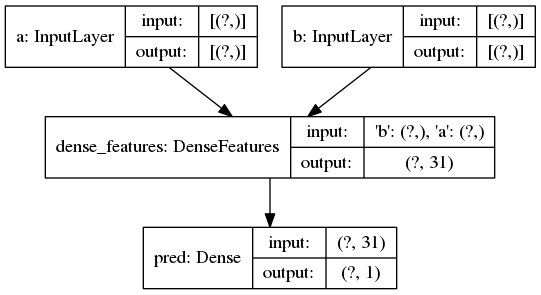

In [3]:
tf.keras.utils.plot_model(model, 'repro_model.png', show_shapes=True)

In [4]:
tf.keras.models.save_model(model, '04_keras/export/savedmodel')

W0717 20:50:38.262684 139664490661632 deprecation.py:506] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1779: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir 04_keras/export/savedmodel

The given SavedModel SignatureDef contains the following input(s):
  inputs['a'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: serving_default_a:0
  inputs['b'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: serving_default_b:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['pred'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [6]:
!find 04_keras/export/savedmodel

04_keras/export/savedmodel
04_keras/export/savedmodel/saved_model.pb
04_keras/export/savedmodel/assets
04_keras/export/savedmodel/variables
04_keras/export/savedmodel/variables/variables.index
04_keras/export/savedmodel/variables/variables.data-00000-of-00001
04_keras/export/savedmodel/variables/checkpoint


In [7]:
# restore from SavedModel
loaded_model = tf.keras.models.load_model('04_keras/export/savedmodel')
loaded_model.predict({
    'a': tf.convert_to_tensor([3]),
    'b': tf.convert_to_tensor([13])
})

ValueError: in converted code:
    relative to /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python:

    keras/saving/saved_model/load.py:239 call
        return call_fn(inputs, *args, **kwargs)
    keras/saving/saved_model/utils.py:46 wrapped_call
        lambda: call_fn(inputs, training=False))
    keras/utils/tf_utils.py:58 smart_cond
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
    framework/smart_cond.py:56 smart_cond
        return false_fn()
    keras/saving/saved_model/utils.py:46 <lambda>
        lambda: call_fn(inputs, training=False))
    eager/def_function.py:417 __call__
        self._initialize(args, kwds, add_initializers_to=initializer_map)
    eager/def_function.py:360 _initialize
        *args, **kwds))
    eager/function.py:1709 _get_concrete_function_internal_garbage_collected
        graph_function, _, _ = self._maybe_define_function(args, kwargs)
    eager/function.py:2013 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    eager/function.py:1899 _create_graph_function
        capture_by_value=self._capture_by_value),
    framework/func_graph.py:795 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    eager/def_function.py:310 wrapped_fn
        return weak_wrapped_fn().__wrapped__(*args, **kwds)
    saved_model/function_deserialization.py:257 restored_function_body
        "\n\n".join(signature_descriptions)))

    ValueError: Could not find matching function to call loaded from the SavedModel. Got:
      Positional arguments (2 total):
        * [<tf.Tensor 'inputs:0' shape=(None, 1) dtype=int32>, <tf.Tensor 'inputs_1:0' shape=(None, 1) dtype=int32>]
        * False
      Keyword arguments: {}
    
    Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.int32, name='inputs/0'), TensorSpec(shape=(None,), dtype=tf.int32, name='inputs/1')]
        * True
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.int32, name='a'), TensorSpec(shape=(None,), dtype=tf.int32, name='b')]
        * True
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.int32, name='inputs/0'), TensorSpec(shape=(None,), dtype=tf.int32, name='inputs/1')]
        * False
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.int32, name='a'), TensorSpec(shape=(None,), dtype=tf.int32, name='b')]
        * False
      Keyword arguments: {}


In [ ]:
%%writefile repro.json
{"a": "2010-02-08 09:17:00+00:00"}

In [ ]:
%%bash
MODEL_NAME=repro
VERSION_NAME=v1
if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    # create model
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=us-central1 $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 10
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --origin=04_keras/export/savedmodel --staging-bucket=gs://cloud-training-demos-ml

In [2]:
## REPRO for @tf.function

import tensorflow as tf
import pandas as pd
import datetime
print(tf.version.VERSION)
import shutil
import os

# serving inputs to model
inputs = {
    'pickup_datetime' : tf.keras.layers.Input(name='a', shape=(), dtype='string')
}

transformed = {}
feature_columns = {}

# hourofday can be done through a tf.strings.substr and works okay
transformed['hourofday'] = tf.keras.layers.Lambda(
        lambda x: tf.strings.to_number(tf.strings.substr(x, 11, 2), out_type=tf.dtypes.int32),
        name='hourofday'
)(inputs['pickup_datetime'])
feature_columns['hourofday'] = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_identity('hourofday', num_buckets=24))

# ADDING THIS CODE CAUSES ERROR
DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
def get_dayofweek(s):
    if type(s) is not str:
        s = s.numpy().decode('utf-8') # if it is a Tensor
    ts = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S %Z")
    return DAYS[ts.weekday()]

print(get_dayofweek('2012-07-05 14:18:00 UTC'))
print(get_dayofweek(tf.constant('2012-07-05 14:18:00 UTC')))

def dayofweek(ts_in):
    return tf.map_fn(
        lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
        ts_in
    )

transformed['dayofweek'] = tf.keras.layers.Lambda(
        lambda x: dayofweek(x),
        name='dayofweek_pyfun'
)(inputs['pickup_datetime'])
transformed['dayofweek'] = tf.keras.layers.Reshape((), name='dayofweek')(transformed['dayofweek'])
feature_columns['dayofweek'] = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = DAYS))
## END ADD

# model architecture
ds = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)
output = tf.keras.layers.Dense(1, name='pred')(ds)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

df = pd.DataFrame.from_dict({
    'pickup_datetime': ['2012-07-05 14:18:00 UTC', '2012-07-05 15:18:00 UTC'],
})
y =  [3.0, 2.0]

# need clean checkpoint path: otherwise get cache error
OUTDIR='/tmp'
shutil.rmtree('{}/checkpoints/'.format(OUTDIR), ignore_errors=True)
checkpoint_path = '{}/checkpoints/taxi'.format(OUTDIR)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit([df['pickup_datetime']], y, steps_per_epoch=1, callbacks=[cp_callback])
model.save('/tmp/savedmodel')

W0717 23:19:11.941735 140226735507200 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4336: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0717 23:19:12.050229 140226735507200 training_utils.py:1150] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.


2.0.0-dev20190717
Wed
Wed
Train on 1 samples

Epoch 00001: saving model to /tmp/checkpoints/taxi
1/1 [==============================] - 0s 123ms/step - loss: 4.6974 - mse: 4.6974


TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: model_1/dense_features_1/dayofweek_indicator/dayofweek_lookup/Const:0